This Jupyter notebook validates the quality and privacy of synthetically generated data during Epoch Analysis phase of my research by loading pre-trained CTGAN models for different service codes, generating synthetic samples, and evaluating them using utility metrics (Hellinger distance), statistical tests (TSTR - Train on Synthetic, Test on Real), and privacy protection measures (DCR Baseline Protection). 

In [1]:
from sdv.single_table import CTGANSynthesizer

# Load CTGAN trained for 500 epochs
ctgan_200 = CTGANSynthesizer.load(
    filepath='models/ctgan_theft_v8_200epochs.pkl'
)

# Load CTGAN trained for 600 epochs
ctgan_600 = CTGANSynthesizer.load(
    filepath='ctgan_theft_v7_600epochs.pkl'
)

# Load CTGAN trained for 800 epochs
ctgan_800 = CTGANSynthesizer.load(
    filepath='ctgan_theft_v4_800epochs.pkl'
)

# Load CTGAN trained for 1200 epochs
ctgan_1200 = CTGANSynthesizer.load(
    filepath='ctgan_theft_v5_1200epochs.pkl'
)

# Load CTGAN trained for 1500 epochs
ctgan_1500 = CTGANSynthesizer.load(
    filepath='ctgan_theft_v6_1500epochs.pkl'
)


/dcs/large/u2164966/MSc_Dissertation/myenv/lib64/python3.12/site-packages/sdv/_utils.py:500: FutureWarning:

The 'load' function will be deprecated in future versions of SDV. Please use 'utils.load_synthesizer' instead.

/dcs/large/u2164966/MSc_Dissertation/myenv/lib64/python3.12/site-packages/sdv/_utils.py:310: SDVVersionWarning:

You are currently on SDV version 1.26.0 but this synthesizer was created on version 1.23.0. The latest bug fixes and features may not be available for this synthesizer. To see these enhancements, create and train a new synthesizer on this version.

/dcs/large/u2164966/MSc_Dissertation/myenv/lib64/python3.12/site-packages/sdv/_utils.py:500: FutureWarning:

The 'load' function will be deprecated in future versions of SDV. Please use 'utils.load_synthesizer' instead.

/dcs/large/u2164966/MSc_Dissertation/myenv/lib64/python3.12/site-packages/sdv/_utils.py:310: SDVVersionWarning:

You are currently on SDV version 1.26.0 but this synthesizer was created on version

In [2]:
import pandas as pd
# loading data
df_filtered = pd.read_pickle("filtered_data/df_filtered_theft.pkl")

In [3]:
# Generating synthetic data

synthetic_200 = ctgan_200.sample(
    num_rows=87517,
    batch_size=1000
)

synthetic_600 = ctgan_600.sample(
    num_rows=87517,
    batch_size=1000
)

synthetic_800 = ctgan_800.sample(
    num_rows=87517,
    batch_size=1000
)

synthetic_1200 = ctgan_1200.sample(
    num_rows=87517,
    batch_size=1000
)

synthetic_1500 = ctgan_1500.sample(
    num_rows=87517,
    batch_size=1000
)


Sampling rows: : 88000it [00:02, 36395.51it/s]                         
Sampling rows: : 88000it [00:02, 39182.08it/s]                         
Sampling rows: : 88000it [00:02, 38185.59it/s]                         
Sampling rows: : 88000it [00:02, 37829.40it/s]                         
Sampling rows: : 88000it [00:02, 37174.86it/s]                         


## Hellingers Distance

In [4]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
# Function to compute Hellinger distance (already defined)
def hellinger(p, q):
    p = np.asarray(p, dtype=np.float64)
    q = np.asarray(q, dtype=np.float64)
    p = p / p.sum()
    q = q / q.sum()
    return np.linalg.norm(np.sqrt(p) - np.sqrt(q)) / np.sqrt(2)

def compare_columns(real: pd.DataFrame, synth: pd.DataFrame, bins=10):
    distances = {}
    for col in real.columns:
        if real[col].dtype == 'object' or pd.api.types.is_categorical_dtype(real[col]):
            categories = list(set(real[col].unique()) | set(synth[col].unique()))
            real_counts = real[col].value_counts(normalize=True).reindex(categories, fill_value=0)
            synth_counts = synth[col].value_counts(normalize=True).reindex(categories, fill_value=0)
            dist = hellinger(real_counts.values, synth_counts.values)
        else:
            col_min = min(real[col].min(), synth[col].min())
            col_max = max(real[col].max(), synth[col].max())
            bin_edges = np.linspace(col_min, col_max, bins + 1)
            real_hist, _ = np.histogram(real[col], bins=bin_edges)
            synth_hist, _ = np.histogram(synth[col], bins=bin_edges)
            dist = hellinger(real_hist, synth_hist)
        distances[col] = dist
    return distances

# Prepare dictionary to store results
all_results = {}

# Iterate over all synthetic datasets
for name, synth_data in {
    'synthetic_200': synthetic_200,
    'synthetic_600': synthetic_600,
    'synthetic_800': synthetic_800,
    'synthetic_1200': synthetic_1200,
    'synthetic_1500': synthetic_1500,
}.items():
    # Copy and convert object columns to categorical
    synth_copy = synth_data.copy()
    obj_cols = synth_copy.select_dtypes(include='object').columns
    synth_copy[obj_cols] = synth_copy[obj_cols].astype('category')
    
    # Compare with real data
    distances = compare_columns(df_filtered, synth_copy, bins=10)
    all_results[name] = distances

# Convert to DataFrame for easy comparison
hellinger_df = pd.DataFrame(all_results)

In [10]:
hellinger_df

,synthetic_200,synthetic_600,synthetic_800,synthetic_1200,synthetic_1500
hour_created,0.099954,0.062850,0.051284,0.056655,0.064202
max_final_priority,0.089303,0.123282,0.101151,0.114832,0.131940
inc_resourced,0.094774,0.111799,0.088306,0.115518,0.058129
scrs_crime_inc,0.089583,0.093933,0.106057,0.081513,0.108019
service_code_description,0.000000,0.000000,0.000000,0.000000,0.000000
multi_member_ward,0.141387,0.103378,0.093016,0.120062,0.133703
date_seq,0.147635,0.087795,0.033986,0.041041,0.052533


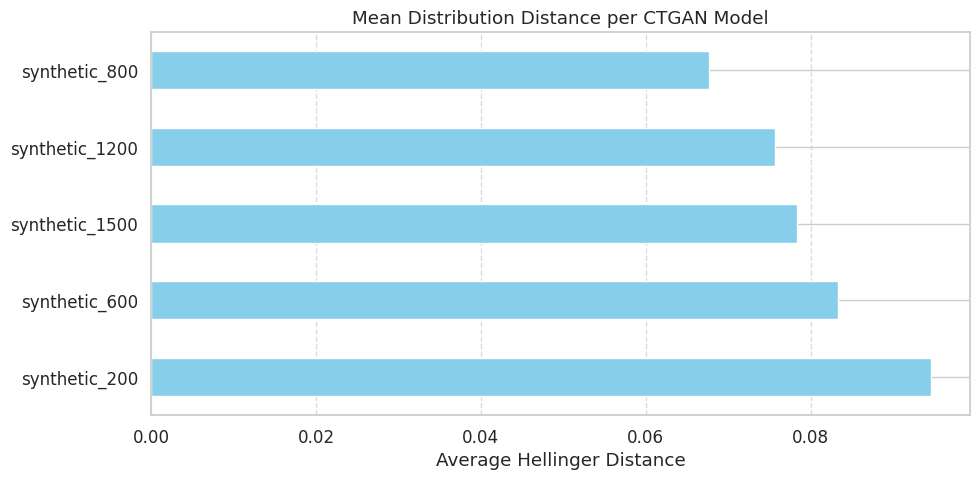

In [19]:
import matplotlib.pyplot as plt

# Calculate average Hellinger distance per model
mean_hellinger = hellinger_df.mean().sort_values()

plt.figure(figsize=(10, 5))
mean_hellinger.plot(kind='barh', color='skyblue')
plt.xlabel("Average Hellinger Distance")
plt.title("Mean Distribution Distance per CTGAN Model")
plt.gca().invert_yaxis()
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## Propensity Score

In [5]:
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")

# Prepare a dictionary to hold results
propensity_distributions = {}

# Iterate over each synthetic dataset
for name, synth_df in {
    'synthetic_200': synthetic_200,
    'synthetic_600': synthetic_600,
    'synthetic_800': synthetic_800,
    'synthetic_1200': synthetic_1200,
    'synthetic_1500': synthetic_1500
}.items():
    
    print(f"\n🔍 Evaluating: {name}")
    
    # Copy data to avoid in-place modifications
    dft_copy = df_filtered.copy()
    synth_copy = synth_df.copy()

    # Add indicator column
    dft_copy["is_real"] = 1
    synth_copy["is_real"] = 0

    # Combine datasets
    full = pd.concat([dft_copy, synth_copy], ignore_index=True)

    # Separate features and target
    X = full.drop('is_real', axis=1)
    y = full['is_real']

    # Convert object columns to categorical
    for col in X.select_dtypes(include='object').columns:
        X[col] = X[col].astype('category')

    # Split into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42, stratify=y
    )

    # Train LightGBM classifier
    lgbm = lgb.LGBMClassifier(objective='binary', random_state=42)
    lgbm.fit(X_train, y_train)

    # Predict propensity scores
    full['p_score'] = lgbm.predict_proba(X)[:, 1]

    # Show summary stats
    print(full.groupby('is_real')['p_score'].describe())

    # Store for final plotting
    real_scores = full[full['is_real'] == 1]['p_score']
    synthetic_scores = full[full['is_real'] == 0]['p_score']
    propensity_distributions[name] = {
        'real': real_scores,
        'synthetic': synthetic_scores
    }



🔍 Evaluating: synthetic_200
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 61262, number of negative: 61261
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001344 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 603
[LightGBM] [Info] Number of data points in the train set: 122523, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500004 -> initscore=0.000016
[LightGBM] [Info] Start training from score 0.000016
           count      mean       std       min       25%       50%       75%  \
is_real                                                                        
0        87517.0  0.39826

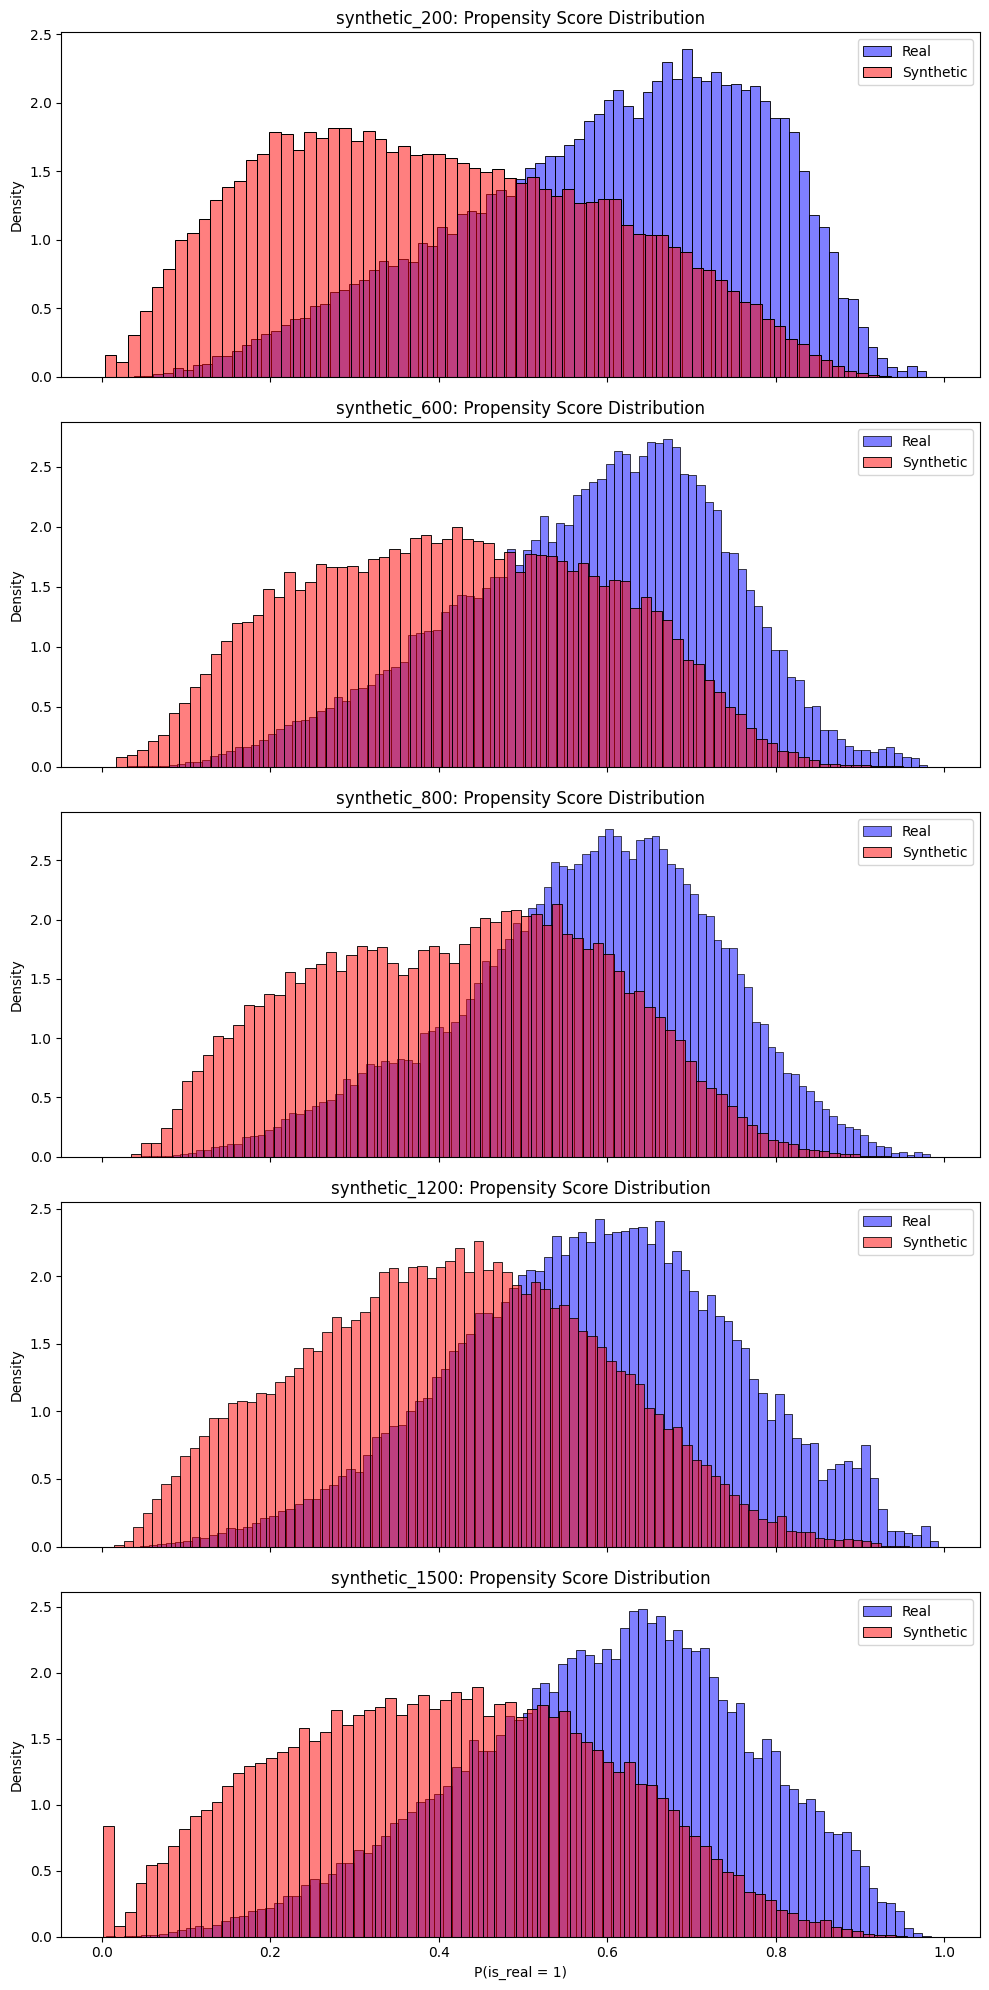

In [6]:
# One subplot per model
n_models = len(propensity_distributions)
fig, axes = plt.subplots(n_models, 1, figsize=(10, 4 * n_models), sharex=True)

for i, (name, scores) in enumerate(propensity_distributions.items()):
    ax = axes[i]
    sns.histplot(scores['real'], color='blue', stat='density', alpha=0.5, label='Real', ax=ax)
    sns.histplot(scores['synthetic'], color='red', stat='density', alpha=0.5, label='Synthetic', ax=ax)
    ax.set_title(f"{name}: Propensity Score Distribution")
    ax.set_xlabel("P(is_real = 1)")
    ax.set_ylabel("Density")
    ax.legend()

plt.tight_layout()
plt.show()


In [7]:
# Summary: mean gap between real and synthetic propensity scores
propensity_gap_summary = []

for model_name, scores in propensity_distributions.items():
    real_mean = scores['real'].mean()
    synth_mean = scores['synthetic'].mean()
    gap = abs(real_mean - synth_mean)

    propensity_gap_summary.append({
        'model': model_name,
        'real_mean': real_mean,
        'synth_mean': synth_mean,
        'gap': gap
    })

gap_df = pd.DataFrame(propensity_gap_summary).sort_values(by='gap')

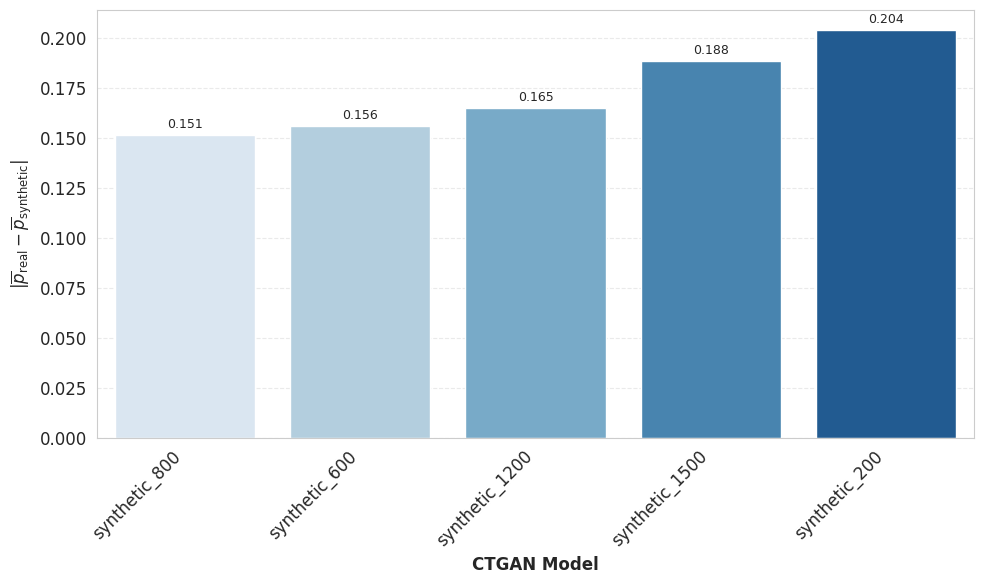

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.cm as cm

# Create figure and axis objects
fig, ax = plt.subplots(figsize=(10, 6))

# Use whitegrid style
sns.set_style("whitegrid")

sns.color_palette("Blues", as_cmap=True)

# Create the barplot with blue gradient
bars = sns.barplot(
    data=gap_df, 
    x='model', 
    y='gap', 
    palette="Blues",
    ax=ax
)

# Title and labels with your consistent formatting
# ax.set_title('Mean Propensity Score Gap: Real vs Synthetic', 
#              fontsize=14, 
#              fontweight='bold')

# LaTeX formatted y-axis label
ax.set_ylabel('$|\\overline{p}_{\\text{real}}-\\overline{p}_{\\text{synthetic}}|$', 
             fontsize=12, 
             fontweight='semibold')

ax.set_xlabel('CTGAN Model', 
             fontsize=12, 
             fontweight='semibold')

# Improve x-tick readability
plt.setp(ax.get_xticklabels(), rotation=45, ha='right')

# Grid styling to match your other plots
ax.grid(axis='y', linestyle='--', alpha=0.4)

# Add value labels on bars
for i, bar in enumerate(ax.patches):
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width()/2.,
        height + 0.002,  # Slight offset above bar
        f"{height:.3f}",
        ha='center', 
        va='bottom', 
        fontsize=9
    )

# Apply tight layout
plt.tight_layout()

# Show the plot
plt.show()

## Other Metrics

In [17]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import OrdinalEncoder, MinMaxScaler
from sklearn.metrics.pairwise import pairwise_kernels, pairwise_distances
from scipy.spatial.distance import jensenshannon
from sdmetrics.reports.single_table import QualityReport
from sdv.metadata import SingleTableMetadata

synthetic_datasets = {
    'synthetic_200': synthetic_200,
    'synthetic_600': synthetic_600,
    'synthetic_800': synthetic_800,
    'synthetic_1200': synthetic_1200,
    'synthetic_1500': synthetic_1500,
}

def _mmd2_gaussian(X, Y, subsample=None):
    rng = np.random.default_rng(42)
    if subsample and len(X) > subsample:
        X = X[rng.choice(len(X), subsample, replace=False)]
    if subsample and len(Y) > subsample:
        Y = Y[rng.choice(len(Y), subsample, replace=False)]

    Z = np.vstack([X, Y])
    dists = pairwise_distances(Z, metric='euclidean')
    gamma = 1.0 / (2.0 * np.median(dists[dists > 0]) ** 2)

    Kxx = pairwise_kernels(X, X, metric='rbf', gamma=gamma)
    Kyy = pairwise_kernels(Y, Y, metric='rbf', gamma=gamma)
    Kxy = pairwise_kernels(X, Y, metric='rbf', gamma=gamma)

    return Kxx.mean() + Kyy.mean() - 2 * Kxy.mean()

# ───────────────────────────────────────────────────────────────
# Helper: Prepare numeric matrix for MMD (Ordinal+MinMax scaling)
# ───────────────────────────────────────────────────────────────
def _prep_for_mmd(df, cat_cols):
    num_cols = [c for c in df.columns if c not in cat_cols]
    enc = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
    df_enc = df.copy()

    if cat_cols:
        df_enc[cat_cols] = enc.fit_transform(df[cat_cols])

    scaler = MinMaxScaler()
    df_enc[num_cols + cat_cols] = scaler.fit_transform(df_enc[num_cols + cat_cols])
    return df_enc[num_cols + cat_cols].to_numpy()

# ───────────────────────────────────────────────────────────────
# Helper: Jensen–Shannon divergence for one column
# ───────────────────────────────────────────────────────────────
def _js_col(real_col, synth_col, bins=30):
    if pd.api.types.is_numeric_dtype(real_col):
        hist_r, bin_edges = np.histogram(real_col, bins=bins, density=True)
        hist_s, _         = np.histogram(synth_col, bins=bin_edges, density=True)
    else:
        cats = pd.Series(list(set(real_col) | set(synth_col)))
        hist_r = real_col.value_counts(normalize=True).reindex(cats, fill_value=0).values
        hist_s = synth_col.value_counts(normalize=True).reindex(cats, fill_value=0).values
    return jensenshannon(hist_r, hist_s, base=2) ** 2

# ───────────────────────────────────────────────────────────────
# Identify categorical columns from the real dataset
# ───────────────────────────────────────────────────────────────
cat_cols = [
    c for c in df_filtered.columns
    if df_filtered[c].dtype == 'object' or str(df_filtered[c].dtype).startswith('category')
]

# ───────────────────────────────────────────────────────────────
# Run metrics for all synthetic datasets
# ───────────────────────────────────────────────────────────────
results = []

for model_name, synthetic_data in synthetic_datasets.items():
    print(f"🔍 Evaluating: {model_name}")

    # 1. MMD²
    X_real = _prep_for_mmd(df_filtered, cat_cols)
    X_synth = _prep_for_mmd(synthetic_data, cat_cols)
    mmd2 = _mmd2_gaussian(X_real, X_synth, subsample=20000)

    # 2. JS divergence (average over columns)
    js_divs = [
        _js_col(df_filtered[col], synthetic_data[col])
        for col in df_filtered.columns
    ]
    js_mean = np.mean(js_divs)

    # 3. SDMetrics QualityReport
    metadata = SingleTableMetadata()
    metadata.detect_from_dataframe(df_filtered)

    qr = QualityReport()
    qr.generate(
        real_data=df_filtered,
        synthetic_data=synthetic_data,
        metadata=metadata.to_dict()
    )
    quality_score = qr.get_score()

    # Save results
    results.append({
        'Model': model_name,
        'MMD²': mmd2,
        'JS Divergence (mean)': js_mean,
        'Quality Score': quality_score
    })

# ───────────────────────────────────────────────────────────────
# Convert to DataFrame and sort by JS divergence
# ───────────────────────────────────────────────────────────────
metrics_df = pd.DataFrame(results).sort_values(by='JS Divergence (mean)').reset_index(drop=True)
print(metrics_df)

🔍 Evaluating: synthetic_200
Generating report ...

(1/2) Evaluating Column Shapes: |██████████| 7/7 [00:00<00:00, 38.00it/s]|
Column Shapes Score: 90.35%

(2/2) Evaluating Column Pair Trends: |██████████| 21/21 [00:00<00:00, 45.33it/s]|
Column Pair Trends Score: 84.21%

Overall Score (Average): 87.28%

🔍 Evaluating: synthetic_600
Generating report ...

(1/2) Evaluating Column Shapes: |██████████| 7/7 [00:00<00:00, 31.79it/s]|
Column Shapes Score: 91.4%

(2/2) Evaluating Column Pair Trends: |██████████| 21/21 [00:00<00:00, 44.95it/s]|
Column Pair Trends Score: 82.45%

Overall Score (Average): 86.93%

🔍 Evaluating: synthetic_800
Generating report ...

(1/2) Evaluating Column Shapes: |██████████| 7/7 [00:00<00:00, 30.08it/s]|
Column Shapes Score: 92.96%

(2/2) Evaluating Column Pair Trends: |██████████| 21/21 [00:00<00:00, 45.55it/s]|
Column Pair Trends Score: 87.36%

Overall Score (Average): 90.16%

🔍 Evaluating: synthetic_1200
Generating report ...

(1/2) Evaluating Column Shapes: |████

In [4]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import OrdinalEncoder, MinMaxScaler
from sklearn.metrics.pairwise import pairwise_kernels, pairwise_distances
from scipy.spatial.distance import jensenshannon
from sdmetrics.reports.single_table import QualityReport
from sdv.metadata import SingleTableMetadata

synthetic_datasets = {
    'synthetic_200': synthetic_200,
    'synthetic_600': synthetic_600,
    'synthetic_800': synthetic_800,
    'synthetic_1200': synthetic_1200,
    'synthetic_1500': synthetic_1500,
}

def _mmd2_gaussian(X, Y, subsample=None):
    rng = np.random.default_rng(42)
    if subsample and len(X) > subsample:
        X = X[rng.choice(len(X), subsample, replace=False)]
    if subsample and len(Y) > subsample:
        Y = Y[rng.choice(len(Y), subsample, replace=False)]

    Z = np.vstack([X, Y])
    dists = pairwise_distances(Z, metric='euclidean')
    gamma = 1.0 / (2.0 * np.median(dists[dists > 0]) ** 2)

    Kxx = pairwise_kernels(X, X, metric='rbf', gamma=gamma)
    Kyy = pairwise_kernels(Y, Y, metric='rbf', gamma=gamma)
    Kxy = pairwise_kernels(X, Y, metric='rbf', gamma=gamma)

    return Kxx.mean() + Kyy.mean() - 2 * Kxy.mean()

def _prep_for_mmd(df, cat_cols):
    num_cols = [c for c in df.columns if c not in cat_cols]
    enc = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
    df_enc = df.copy()

    if cat_cols:
        df_enc[cat_cols] = enc.fit_transform(df[cat_cols])

    scaler = MinMaxScaler()
    df_enc[num_cols + cat_cols] = scaler.fit_transform(df_enc[num_cols + cat_cols])
    return df_enc[num_cols + cat_cols].to_numpy()

def _js_col(real_col, synth_col, bins=30):
    if pd.api.types.is_numeric_dtype(real_col):
        hist_r, bin_edges = np.histogram(real_col, bins=bins, density=True)
        hist_s, _         = np.histogram(synth_col, bins=bin_edges, density=True)
    else:
        cats = pd.Series(list(set(real_col) | set(synth_col)))
        hist_r = real_col.value_counts(normalize=True).reindex(cats, fill_value=0).values
        hist_s = synth_col.value_counts(normalize=True).reindex(cats, fill_value=0).values
    return jensenshannon(hist_r, hist_s, base=2) ** 2

cat_cols = [
    c for c in df_filtered.columns
    if df_filtered[c].dtype == 'object' or str(df_filtered[c].dtype).startswith('category')
]

results = []

for model_name, synthetic_data in synthetic_datasets.items():
    print(f"🔍 Evaluating: {model_name}")

    X_real = _prep_for_mmd(df_filtered, cat_cols)
    X_synth = _prep_for_mmd(synthetic_data, cat_cols)
    mmd2 = _mmd2_gaussian(X_real, X_synth, subsample=20000)

    js_divs = [
        _js_col(df_filtered[col], synthetic_data[col])
        for col in df_filtered.columns
    ]
    js_mean = np.mean(js_divs)

    metadata = SingleTableMetadata()
    metadata.detect_from_dataframe(df_filtered)

    qr = QualityReport()
    qr.generate(
        real_data=df_filtered,
        synthetic_data=synthetic_data,
        metadata=metadata.to_dict()
    )

    shape_details = qr.get_details(property_name='Column Shapes')
    print(shape_details[['Column', 'Metric', 'Score']].head())

    results.append({
        'Model': model_name,
        'MMD²': mmd2,
        'JS Divergence (mean)': js_mean
    })

metrics_df = pd.DataFrame(results).sort_values(by='JS Divergence (mean)').reset_index(drop=True)
print(metrics_df)


🔍 Evaluating: synthetic_200
Generating report ...

(1/2) Evaluating Column Shapes: |██████████| 7/7 [00:00<00:00, 37.92it/s]|
Column Shapes Score: 90.4%

(2/2) Evaluating Column Pair Trends: |██████████| 21/21 [00:00<00:00, 40.94it/s]|
Column Pair Trends Score: 84.35%

Overall Score (Average): 87.37%

                     Column        Metric     Score
0              hour_created  KSComplement  0.921330
1        max_final_priority  TVComplement  0.915833
2             inc_resourced  TVComplement  0.871933
3            scrs_crime_inc  TVComplement  0.930631
4  service_code_description  TVComplement  1.000000
🔍 Evaluating: synthetic_600
Generating report ...

(1/2) Evaluating Column Shapes: |██████████| 7/7 [00:00<00:00, 31.99it/s]|
Column Shapes Score: 91.4%

(2/2) Evaluating Column Pair Trends: |██████████| 21/21 [00:00<00:00, 45.22it/s]|
Column Pair Trends Score: 82.6%

Overall Score (Average): 87.0%

                     Column        Metric     Score
0              hour_created  KSC

In [ ]:
### Fixing issues in the MMD and Jensen measurements
import numpy as np
import pandas as pd
from sklearn.preprocessing import OrdinalEncoder, MinMaxScaler
from sklearn.metrics.pairwise import pairwise_kernels, pairwise_distances
from scipy.spatial.distance import jensenshannon
from sdmetrics.reports.single_table import QualityReport
from sdv.metadata import SingleTableMetadata

# This part is untouched, assuming these variables are defined in your environment
synthetic_datasets = {
    'synthetic_200': synthetic_200,
    'synthetic_600': synthetic_600,
    'synthetic_800': synthetic_800,
    'synthetic_1200': synthetic_1200,
    'synthetic_1500': synthetic_1500,
}

# This function is implemented correctly and remains untouched.
def _mmd2_gaussian(X, Y, subsample=None):
    rng = np.random.default_rng(42)
    if subsample and len(X) > subsample:
        X = X[rng.choice(len(X), subsample, replace=False)]
    if subsample and len(Y) > subsample:
        Y = Y[rng.choice(len(Y), subsample, replace=False)]

    Z = np.vstack([X, Y])
    dists = pairwise_distances(Z, metric='euclidean')
    gamma = 1.0 / (2.0 * np.median(dists[dists > 0]) ** 2)

    Kxx = pairwise_kernels(X, X, metric='rbf', gamma=gamma)
    Kyy = pairwise_kernels(Y, Y, metric='rbf', gamma=gamma)
    Kxy = pairwise_kernels(X, Y, metric='rbf', gamma=gamma)

    return Kxx.mean() + Kyy.mean() - 2 * Kxy.mean()

# The flawed _prep_for_mmd function has been REMOVED.
# The correct logic is now in the main loop.

# This function is implemented correctly and remains untouched.
def _js_col(real_col, synth_col, bins=30):
    if pd.api.types.is_numeric_dtype(real_col):
        hist_r, bin_edges = np.histogram(real_col, bins=bins, density=True)
        hist_s, _         = np.histogram(synth_col, bins=bin_edges, density=True)
    else:
        cats = pd.Series(list(set(real_col) | set(synth_col)))
        hist_r = real_col.value_counts(normalize=True).reindex(cats, fill_value=0).values
        hist_s = synth_col.value_counts(normalize=True).reindex(cats, fill_value=0).values
    return jensenshannon(hist_r, hist_s, base=2) ** 2


# Define column types based on the real data
cat_cols = [
    c for c in df_filtered.columns
    if df_filtered[c].dtype == 'object' or str(df_filtered[c].dtype).startswith('category')
]
num_cols = [c for c in df_filtered.columns if c not in cat_cols]
all_cols = num_cols + cat_cols # Maintain consistent column order

# 1. Initialize and FIT transformers ONCE on the REAL data
enc = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
scaler = MinMaxScaler()

# Create a temporary copy for fitting to avoid altering the original df_filtered
df_filtered_processed = df_filtered.copy()

if cat_cols:
    df_filtered_processed[cat_cols] = enc.fit_transform(df_filtered[cat_cols])

scaler.fit(df_filtered_processed[all_cols])

# 2. Pre-process the real data ONCE using the fitted transformers
X_real = scaler.transform(df_filtered_processed[all_cols])


results = []

for model_name, synthetic_data in synthetic_datasets.items():
    print(f"🔍 Evaluating: {model_name}")

    # 3. Transform each synthetic dataset using the SAME FITTED transformers
    synthetic_data_processed = synthetic_data.copy()
    if cat_cols:
        synthetic_data_processed[cat_cols] = enc.transform(synthetic_data[cat_cols])
    
    X_synth = scaler.transform(synthetic_data_processed[all_cols])
    
    # Now the MMD² calculation is meaningful
    mmd2 = _mmd2_gaussian(X_real, X_synth, subsample=20000)


    # The rest of your loop logic is correct and remains untouched
    js_divs = [
        _js_col(df_filtered[col], synthetic_data[col])
        for col in df_filtered.columns
    ]
    js_mean = np.mean(js_divs)

    metadata = SingleTableMetadata()
    metadata.detect_from_dataframe(df_filtered)

    qr = QualityReport()
    qr.generate(
        real_data=df_filtered,
        synthetic_data=synthetic_data,
        metadata=metadata.to_dict()
    )

    shape_details = qr.get_details(property_name='Column Shapes')
    print(shape_details[['Column', 'Metric', 'Score']].head())

    results.append({
        'Model': model_name,
        'MMD²': mmd2,
        'JS Divergence (mean)': js_mean
    })

# This part is untouched
metrics_df = pd.DataFrame(results).sort_values(by='JS Divergence (mean)').reset_index(drop=True)
print(metrics_df)

🔍 Evaluating: synthetic_200
Generating report ...

(1/2) Evaluating Column Shapes: |██████████| 7/7 [00:00<00:00, 38.96it/s]|
Column Shapes Score: 90.4%

(2/2) Evaluating Column Pair Trends: |██████████| 21/21 [00:00<00:00, 45.22it/s]|
Column Pair Trends Score: 84.35%

Overall Score (Average): 87.37%

                     Column        Metric     Score
0              hour_created  KSComplement  0.921330
1        max_final_priority  TVComplement  0.915833
2             inc_resourced  TVComplement  0.871933
3            scrs_crime_inc  TVComplement  0.930631
4  service_code_description  TVComplement  1.000000
🔍 Evaluating: synthetic_600
Generating report ...

(1/2) Evaluating Column Shapes: |██████████| 7/7 [00:00<00:00, 31.83it/s]|
Column Shapes Score: 91.4%

(2/2) Evaluating Column Pair Trends: |██████████| 21/21 [00:00<00:00, 45.67it/s]|
Column Pair Trends Score: 82.53%

Overall Score (Average): 86.97%

                     Column        Metric     Score
0              hour_created  K

## Plots

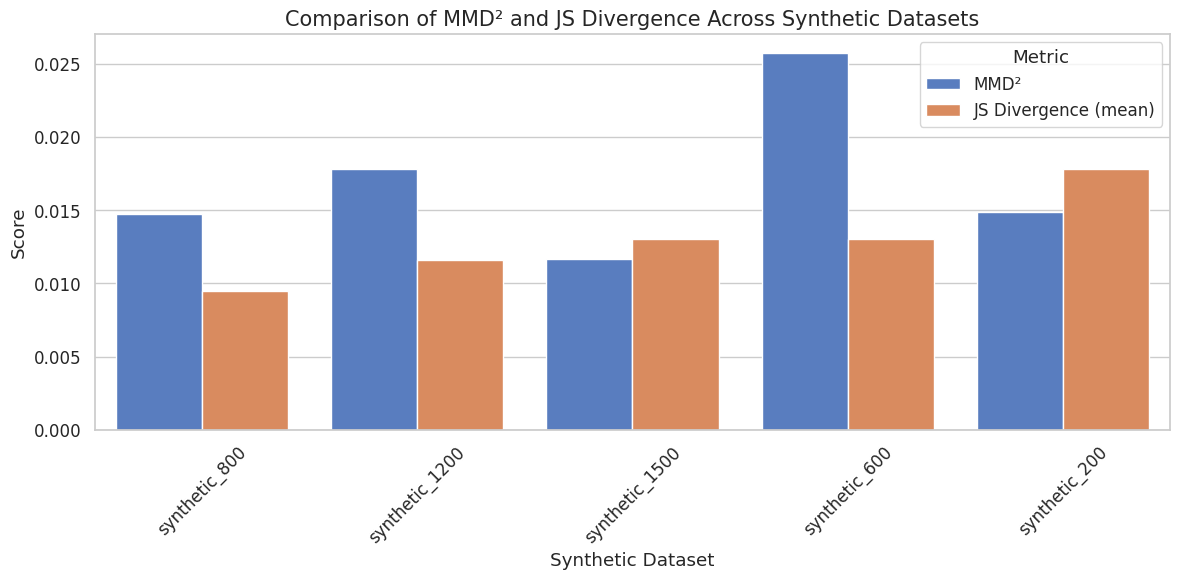

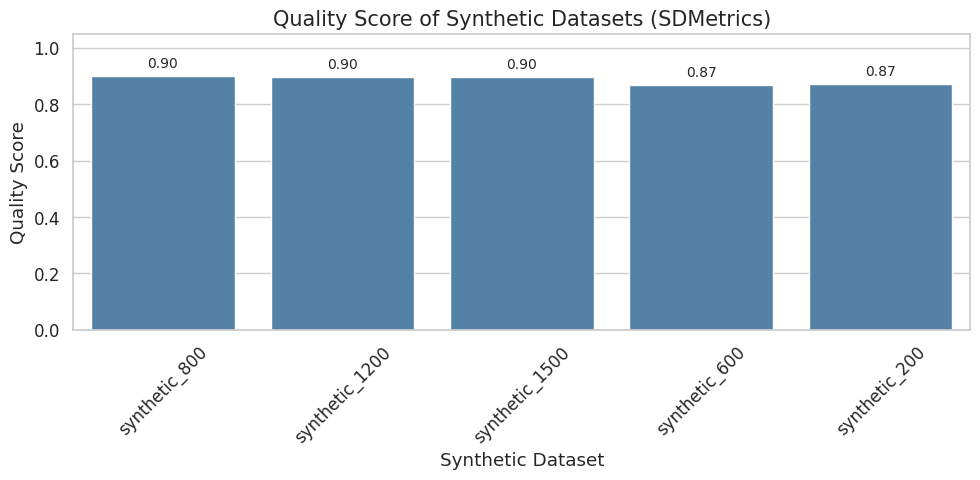

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid", palette="muted", font_scale=1.1)

# ───────────────────────────────────────────────
# Plot 1: MMD² and JS Divergence
# ───────────────────────────────────────────────
metrics_subset = metrics_df[["Model", "MMD²", "JS Divergence (mean)"]]
melted_metrics = metrics_subset.melt(id_vars="Model", 
                                     var_name="Metric", 
                                     value_name="Score")

plt.figure(figsize=(12, 6))
ax1 = sns.barplot(data=melted_metrics, x="Model", y="Score", hue="Metric")
ax1.set_title("Comparison of MMD² and JS Divergence Across Synthetic Datasets", fontsize=15)
ax1.set_ylabel("Score")
ax1.set_xlabel("Synthetic Dataset")
plt.xticks(rotation=45)
plt.legend(title="Metric")
plt.tight_layout()
plt.show()

# ───────────────────────────────────────────────
# Plot 2: Quality Score (separate)
# ───────────────────────────────────────────────
plt.figure(figsize=(10, 5))
ax2 = sns.barplot(data=metrics_df, x="Model", y="Quality Score", color="steelblue")
ax2.set_title("Quality Score of Synthetic Datasets (SDMetrics)", fontsize=15)
ax2.set_ylabel("Quality Score")
ax2.set_xlabel("Synthetic Dataset")
plt.xticks(rotation=45)
plt.ylim(0, 1.05)
for i, val in enumerate(metrics_df["Quality Score"]):
    ax2.text(i, val + 0.02, f"{val:.2f}", ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

## Heat Map

In [33]:
# loading lookup file
lookup = pd.read_csv('DataZone2011lookup_2024-12-16.csv', encoding='latin1')
import unicodedata

# Function to normalize multi_member_ward values
def normalize_ward_name(name):
    if pd.isnull(name):
        return name
    name = unicodedata.normalize("NFKD", name).encode("ascii", "ignore").decode("utf-8")
    name = name.replace("&", "and").replace("/", ",").replace("'", "").strip()
    name = ' '.join(name.split())  # remove extra internal spaces
    return name.lower()  # optional: lowercase for consistency

# Apply to real dataset before training
lookup["MMWard_Name"] = lookup["MMWard_Name"].map(normalize_ward_name)

In [37]:
synthetic_data = synthetic_800
df = df_filtered.copy()

✅ All observed wards are in lookup
✅ All synthetic wards are in lookup


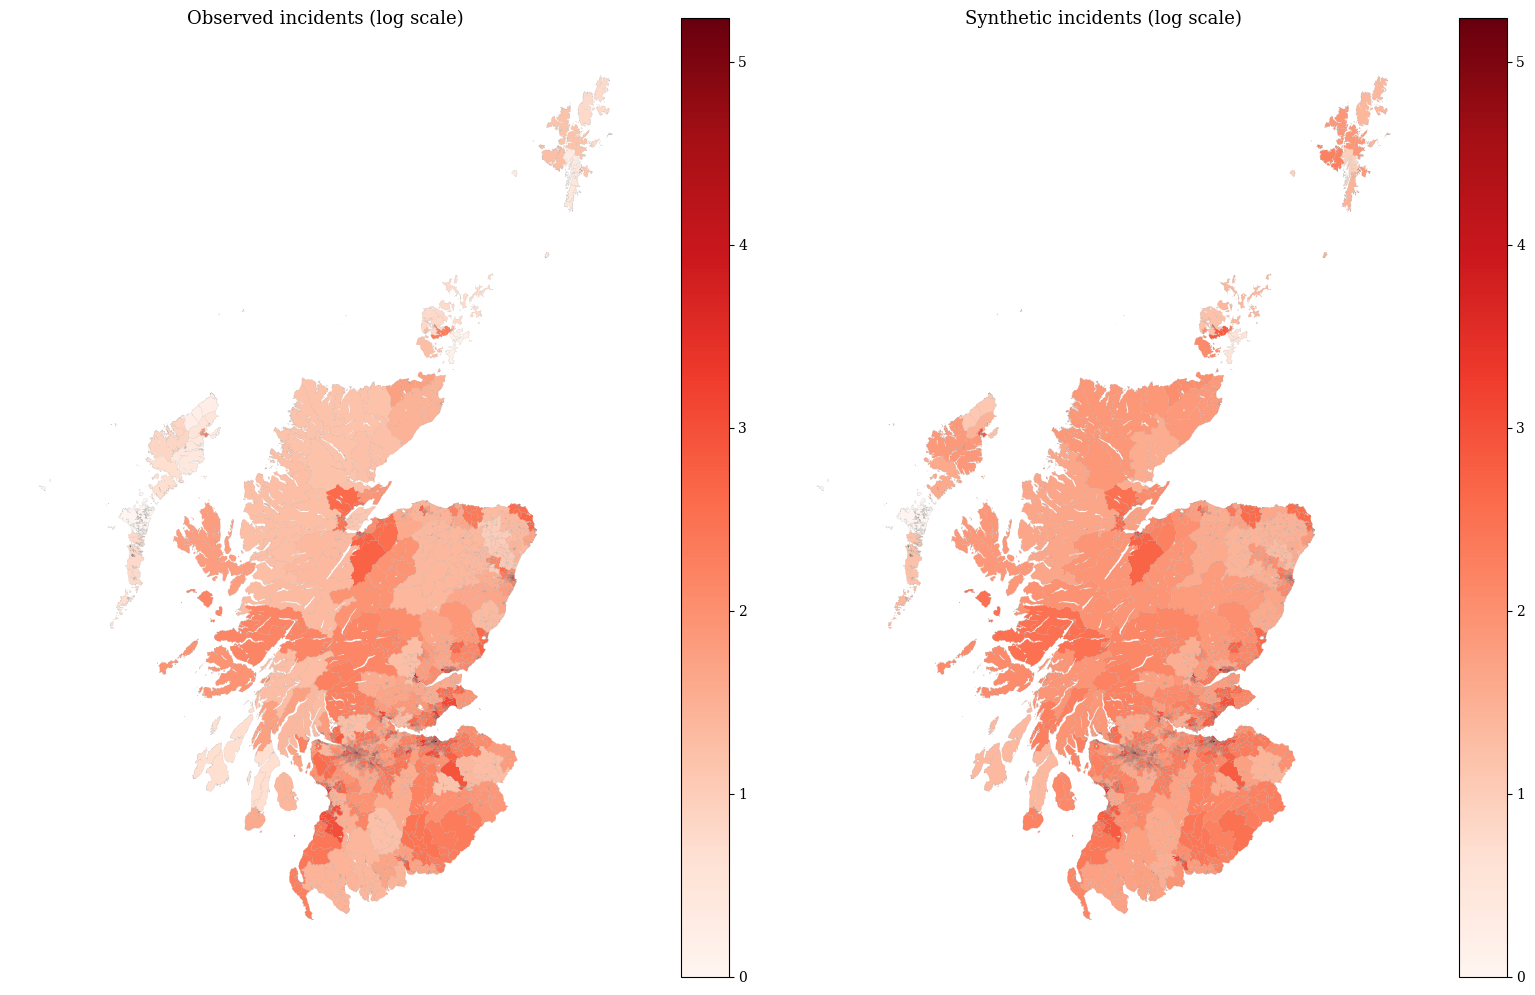

In [38]:
# ───────────────────────────  0.  HOUSEKEEPING  ───────────────────────────
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt

# If your lookup hasn’t been renamed yet, do it once:
lookup = (lookup
          .rename(columns={"DZ2011_Code": "DataZone"})  # <-- change only if needed
          [["DataZone", "MMWard_Name"]])                # keep essentials

# ───────────────────────────  0.1  CHECK FOR UNMAPPED WARDS  ───────────────────────────
lookup_wards = set(lookup["MMWard_Name"].unique())

obs_unique = set(df["multi_member_ward"].dropna().unique())
syn_unique = set(synthetic_data["multi_member_ward"].dropna().unique())

obs_missing = obs_unique - lookup_wards
syn_missing = syn_unique - lookup_wards

if obs_missing:
    print(f"⚠️ Observed wards not in lookup ({len(obs_missing)}): {sorted(obs_missing)[:10]}{'...' if len(obs_missing) > 10 else ''}")
else:
    print("✅ All observed wards are in lookup")

if syn_missing:
    print(f"⚠️ Synthetic wards not in lookup ({len(syn_missing)}): {sorted(syn_missing)[:10]}{'...' if len(syn_missing) > 10 else ''}")
else:
    print("✅ All synthetic wards are in lookup")

# ───────────────────────────  1.  WARD-LEVEL COUNTS  ───────────────────────────
for frame in (df, synthetic_data):
    frame["incident_count"] = 1  # one incident per row

obs_ward = (df
            .groupby("multi_member_ward", as_index=False)["incident_count"]
            .sum()
            .rename(columns={"multi_member_ward": "MMWard_Name",
                             "incident_count": "ward_incidents"}))

syn_ward = (synthetic_data
            .groupby("multi_member_ward", as_index=False)["incident_count"]
            .sum()
            .rename(columns={"multi_member_ward": "MMWard_Name",
                             "incident_count": "ward_incidents"}))

# ───────────────────────────  2.  EXPAND TO DATA-ZONE  ───────────────────────────
dz_per_ward = (lookup
               .groupby("MMWard_Name")
               .size()
               .rename("n_dz")
               .reset_index())

def expand_to_dz(ward_counts: pd.DataFrame) -> pd.DataFrame:
    out = (ward_counts
           .merge(lookup, on="MMWard_Name", how="left")  # duplicate per DZ
           .merge(dz_per_ward, on="MMWard_Name", how="left"))
    out["dz_incidents"] = out["ward_incidents"] / out["n_dz"]  # uniform share
    return out[["DataZone", "dz_incidents"]]

obs_dz = expand_to_dz(obs_ward)
syn_dz = expand_to_dz(syn_ward)

# ───────────────────────────  3.  LOAD & RENAME SHAPEFILE  ───────────────────────────
shp_path = "shape_files/SG_DataZone_Bdry_2011.shp"

shp = (gpd.read_file(shp_path)
       .rename(columns={"DZ_CODE": "DataZone"})  # CHANGE 'DZ_CODE' if needed
       .to_crs(epsg=4326))

# ───────────────────────────  4.  JOIN COUNTS → POLYGONS  ───────────────────────────
def attach_counts(gdf_base: gpd.GeoDataFrame,
                  dz_counts: pd.DataFrame) -> gpd.GeoDataFrame:
    gdf = (gdf_base.merge(dz_counts, on="DataZone", how="left")
                    .fillna({"dz_incidents": 0}))
    gdf["log_inc"] = np.log1p(gdf["dz_incidents"])  # log(x+1)
    return gdf

gdf_obs = attach_counts(shp, obs_dz)
gdf_syn = attach_counts(shp, syn_dz)

# Compute shared limits on the plotted variable (log_inc)
vmin = min(gdf_obs["log_inc"].min(), gdf_syn["log_inc"].min())
vmax = max(gdf_obs["log_inc"].max(), gdf_syn["log_inc"].max())

from matplotlib.colors import Normalize
norm = Normalize(vmin=vmin, vmax=vmax)

# ───────────────────────────  5.  PLOT SIDE-BY-SIDE  ───────────────────────────
fig, axes = plt.subplots(1, 2, figsize=(16, 10), sharex=True, sharey=True)

for ax, gdf_map, title in [
        (axes[0], gdf_obs, "Observed incidents (log scale)"),
        (axes[1], gdf_syn, "Synthetic incidents (log scale)")]:
    gdf_map.plot(
        column="log_inc",
        ax=ax,
        cmap="Reds",
        legend=True,
        edgecolor="grey",
        linewidth=0.05,
        norm=norm,           # <- shared scale
    )
    ax.set_title(title, fontsize=13)
    ax.axis("off")

plt.tight_layout()
plt.show()

## Privacy

In [40]:
from sdmetrics.single_table import DCRBaselineProtection
from sdv.metadata import SingleTableMetadata

table_name = "incidents"
auto_meta = SingleTableMetadata()
auto_meta.detect_from_dataframe(df)
metadata_dict = auto_meta.to_dict()

score = DCRBaselineProtection.compute_breakdown(
    real_data=df,
    synthetic_data=synthetic_200,
    metadata=metadata_dict,
    num_rows_subsample=20000,    # Subsample to 20,000 rows for computation speed
    num_iterations=5             # Run 5 iterations and average for stability
)

score

{'score': 0.0945231276098897,
 'median_DCR_to_real_data': {'synthetic_data': 0.012044687375931059,
  'random_data_baseline': 0.12742745329837413}}

In [41]:
from sdmetrics.single_table import DCRBaselineProtection

table_name = "incidents"
auto_meta = SingleTableMetadata()
auto_meta.detect_from_dataframe(df)
metadata_dict = auto_meta.to_dict()

score = DCRBaselineProtection.compute_breakdown(
    real_data=df,
    synthetic_data=synthetic_600,
    metadata=metadata_dict,
    num_rows_subsample=20000,    # Subsample to 20,000 rows for computation speed
    num_iterations=5             # Run 5 iterations and average for stability
)

score

{'score': 0.08978427369372802,
 'median_DCR_to_real_data': {'synthetic_data': 0.011446346120694633,
  'random_data_baseline': 0.12748838825149206}}

In [42]:
from sdmetrics.single_table import DCRBaselineProtection

table_name = "incidents"
auto_meta = SingleTableMetadata()
auto_meta.detect_from_dataframe(df)
metadata_dict = auto_meta.to_dict()

score = DCRBaselineProtection.compute_breakdown(
    real_data=df,
    synthetic_data=synthetic_800,
    metadata=metadata_dict,
    num_rows_subsample=20000,    # Subsample to 20,000 rows for computation speed
    num_iterations=5             # Run 5 iterations and average for stability
)

score

{'score': 0.08905490221221724,
 'median_DCR_to_real_data': {'synthetic_data': 0.011366520937246466,
  'random_data_baseline': 0.1276348571575082}}

In [ ]:
from sdmetrics.single_table import DCRBaselineProtection
from sdv.metadata import SingleTableMetadata

table_name = "incidents"
auto_meta = SingleTableMetadata()
auto_meta.detect_from_dataframe(df_filtered)
metadata_dict = auto_meta.to_dict()

score = DCRBaselineProtection.compute_breakdown(
    real_data=df_filtered,
    synthetic_data=synthetic_1200,
    metadata=metadata_dict,
    num_rows_subsample=20000,    # Subsample to 20,000 rows for computation speed
    num_iterations=5             # Run 5 iterations and average for stability
)

score

In [ ]:
from sdmetrics.single_table import DCRBaselineProtection

table_name = "incidents"
auto_meta = SingleTableMetadata()
auto_meta.detect_from_dataframe(df_filtered)
metadata_dict = auto_meta.to_dict()

score = DCRBaselineProtection.compute_breakdown(
    real_data=df_filtered,
    synthetic_data=synthetic_1500,
    metadata=metadata_dict,
    num_rows_subsample=20000,    # Subsample to 20,000 rows for computation speed
    num_iterations=5             # Run 5 iterations and average for stability
)

score